<a href="https://colab.research.google.com/github/tanynova99/neural_networks_course/blob/main/Budanova_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory Work №2 - Classification pt.2, "RNN & CNN"
## The task
Даны датасеты на русском языке, необходимо провести их классификацию

0. У второго варианта таргет - tag, у третьего варианта таргет - class

1. При классификации необходимо использовать сверточные слои (CNN) и рекуррентные слои (RNN), вы можете как сделать 2 разные модели, так и объединить в одной.

2. Ещё раз прошу уделить внимание EDA: старайтесь подходить к нему больше как к написанию текста.

3. **my dataset is the second one**

*Для желающих есть третий вариант. Он намного сложнее, но за него можно получить оценку выше 10. В его решении сегментация текстов должна быть строго после train_test_split.*

Сдавать сюда: https://forms.gle/Ks4WpjFm2ViYWcba7

**Дедлайн: 24.01 23:59**



In [ ]:
# !pip install pymorphy2

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D, LSTM
from keras.utils import plot_model

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import os
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from tqdm import tqdm
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import zipfile
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import re
# from pymorphy2 import MorphAnalyzer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# connecting to drive and zip exctractions
drive.mount('/content/drive')

# -u part controls extraction only if new/necessary
# -d creates the directory and extracted files are stored there
!unzip -u "/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/2/var2.zip" -d "/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/2/var2"

df = pd.read_csv('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/2/var2/lyrics.csv')
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/2/var2.zip


,Unnamed: 0,year,tag,lyrics,title
0,14072,2009,pop,[Куплет 1]\nТолько степь вздохнёт едва\nКак Бо...,Степь Step
1,22982,2001,rap,"[Текст песни ""Direct""]\n\n[Интро]\n*Stop been ...",Gang Bangin Shit
2,49151,2006,rap,[Текст песни «Будущие мамы»]\n\n[Припев]\nБуду...,Будущие мамы Expectant Moms
3,50914,2011,rap,Зимнее Утро\n\nКуплет 1\n\nЗимнее утро будильн...,Zimnee Utro - Зимнее Утро
4,79951,2011,rap,[Текст песни «Жук в муравейнике» ft. Schokk]\n...,Жук в муравейнике Beetle in an anthill
5,80907,2012,rap,[Текст песни “Блудный сын” ft. She-Raw]\n\n[Ку...,Блудный сын The Lost Son
6,80923,2011,rap,"[Текст песни «То густо, то пусто»]\n\n[Куплет ...",То густо то пусто Either a Feast or a Fast
7,80943,2010,rap,[Текст песни “Сага об орлах и канарейках”]\n\n...,Сага об орлах и канарейках Saga About Eagles a...
8,81718,2012,rap,[Текст песни «Детектор лжи»]\n\n[Припев]\nЭто ...,Детектор лжи Lie Detector
9,81719,2012,rap,[Текст песни «Песенка Гремлина»]\n\n[Интро]\nГ...,Песенка Гремлина Gremlins Song


## We only need the tag and the lyrics

In [ ]:
df = df.drop('year', axis=1)
df = df.drop('title', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df.head(10)

,tag,lyrics
0,pop,[Куплет 1]\nТолько степь вздохнёт едва\nКак Бо...
1,rap,"[Текст песни ""Direct""]\n\n[Интро]\n*Stop been ..."
2,rap,[Текст песни «Будущие мамы»]\n\n[Припев]\nБуду...
3,rap,Зимнее Утро\n\nКуплет 1\n\nЗимнее утро будильн...
4,rap,[Текст песни «Жук в муравейнике» ft. Schokk]\n...
5,rap,[Текст песни “Блудный сын” ft. She-Raw]\n\n[Ку...
6,rap,"[Текст песни «То густо, то пусто»]\n\n[Куплет ..."
7,rap,[Текст песни “Сага об орлах и канарейках”]\n\n...
8,rap,[Текст песни «Детектор лжи»]\n\n[Припев]\nЭто ...
9,rap,[Текст песни «Песенка Гремлина»]\n\n[Интро]\nГ...


## *Lemmatize took too long therefore aborted*

In [ ]:
''' lemmatizer = MorphAnalyzer()

def to_lemmatize(text):
    tokens = word_tokenize(text)
    tokens_lemmatized = [lemmatizer.parse(token)[0].normal_form for token in tokens
                         if not token in set(stopwords.words('russian'))]
    result = ' '.join(tokens_lemmatized)
    return result '''

" lemmatizer = MorphAnalyzer()\n\ndef to_lemmatize(text):\n    tokens = word_tokenize(text)\n    tokens_lemmatized = [lemmatizer.parse(token)[0].normal_form for token in tokens\n                         if not token in set(stopwords.words('russian'))]\n    result = ' '.join(tokens_lemmatized)\n    return result "

In [ ]:
''' tqdm.pandas()
df['lyrics'] = df['lyrics'].progress_apply(to_lemmatize)
df.head(10) '''

" tqdm.pandas()\ndf['lyrics'] = df['lyrics'].progress_apply(to_lemmatize)\ndf.head(10) "

## Let's investigate: Zeros
We will need the lyrics (**column 3**) and the tag (**column 2**). Both contain 158972 non-null variables, so we don't need to fill in anything with fake data.

In [ ]:
df.shape

(158972, 2)

In [ ]:
# check out null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158972 entries, 0 to 158971
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tag     158972 non-null  object
 1   lyrics  158972 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


## Let's investigate: Duplicates

In [ ]:
# see if they exist - count duplicate values in lyrics column
df2 = len(df['lyrics'])-len(df['lyrics'].drop_duplicates())
df2

488

In [ ]:
df = df.drop_duplicates(subset=['lyrics'])

In [ ]:
df.shape

(158484, 2)

## Let's now clear up the text


In [ ]:
df['lyrics'] = df['lyrics'].str.replace(r'\[.*?\]', '', regex=True) # remove the text in []
df['lyrics'] = df['lyrics'].replace(r'\s+', ' ', regex=True) # replace /n with ' '
df['lyrics'] = df['lyrics'].replace(r'[!"#$%&()*+,./:;<=>?@\[\\\]^_`{|}~]+', '', regex=True) # remove punctiation

In [ ]:
remove_words = ['Куплет 1', 'Куплет 2', 'Куплет 3', 'Припев', 'куплет 1', 'куплет 2', 'куплет 3', 'припев'] # some of the junk words wasn't in brackets
remove_words += stopwords.words('english')
remove_words += stopwords.words('russian')

print(remove_words)

['Куплет 1', 'Куплет 2', 'Куплет 3', 'Припев', 'куплет 1', 'куплет 2', 'куплет 3', 'припев', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',

In [ ]:
pat = r'\b(?:{})\b'.format('|'.join(remove_words))

print(pat)
# basically i create a long long regex that excludes
# the junk words that don't carry too much sense
# the list of remove_words include both ru and eng stop_words
# since there are chunks of english lyrics, not just names

df['lyrics'] = df['lyrics'].str.replace(pat, '')

\b(?:Куплет 1|Куплет 2|Куплет 3|Припев|куплет 1|куплет 2|куплет 3|припев|i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|

<ipython-input-14-4687522864d0>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lyrics'] = df['lyrics'].str.replace(pat, '')


In [ ]:
df.head(10)

,tag,lyrics
0,pop,Только степь вздохнёт едва Как Божию росой тр...
1,rap,Stop fuckin' Gredy Е Loco let' go bitch VIS...
2,rap,Будущие мамы хвастайте телами Парни бойтесь ...
3,rap,Зимнее Утро Зимнее утро будильник «шесть соро...
4,rap,Я помню детстве миг девственник Заняв неизв...
5,rap,Я 30 лет привык псом улице По-разному спра...
6,rap,Я оглянусь назад ещё время остановив А ник...
7,rap,Запомни Люди делятся две категории - орлов ...
8,rap,Это всё правда те зуб даю бля буду Выведи ч...
9,rap,Год назад сидел скамейке общественном парк...


## Let's investigate: Balance

For that we'll see the tags' distrivution in the dataset.

In [ ]:
df.tag.unique() # these are unique values of the attribute "tag"

array(['pop', 'rap', 'rock'], dtype=object)

In [ ]:
df.tag.nunique() # the number of unique values

3

<Axes: >

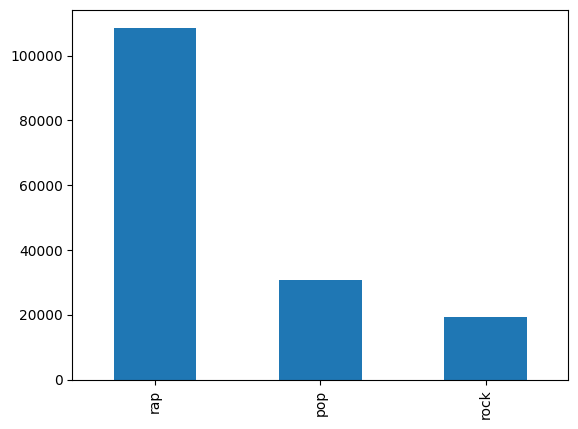

In [ ]:
chart = df.tag.value_counts() # how many rows with that tag we have

chart.plot.bar()

Clearly the dataset is unbalanced. There are two ways to deal with this: expect bad training results for rock and pop labels or make that dataset a little less unbalanced.

## But first we need to encode the text

In [ ]:
labels_dict = {'rap': 0, 'pop' : 1, 'rock': 2}
labels_dict.values()

dict_values([0, 1, 2])

In [ ]:
enc = LabelEncoder()
df['tag'] = enc.fit_transform(df['tag'])

df

,tag,lyrics
0,0,Только степь вздохнёт едва Как Божию росой тр...
1,1,Stop fuckin' Gredy Е Loco let' go bitch VIS...
2,1,Будущие мамы хвастайте телами Парни бойтесь ...
3,1,Зимнее Утро Зимнее утро будильник «шесть соро...
4,1,Я помню детстве миг девственник Заняв неизв...
...,...,...
158967,2,Сколько историй вся жизнь повторе Вернулся и...
158968,0,Я могу найти Милкис дорой Купи пожалуйста М...
158969,1,Мутный мрак records Камоловский синдикат prod...
158970,1,Интро Evil empire – Laughing way bank GO D...


In [ ]:
BOW = []

def clear_text(text):
    clear = re.findall('[ёа-яa-z]+', text.lower())
    BOW.extend((clear))
    clear = ' '.join(clear)
    return clear

tqdm.pandas()

df['lyrics'] = df['lyrics'].progress_apply(clear_text)

BOW = Counter(BOW)

text_lengths = df['lyrics'].apply(lambda x: len(x.split()))
len(BOW), np.median(text_lengths, axis=0), np.mean(text_lengths, axis=0)

100%|██████████| 158484/158484 [00:17<00:00, 8996.35it/s]


(595972, 159.0, 176.99730572171325)

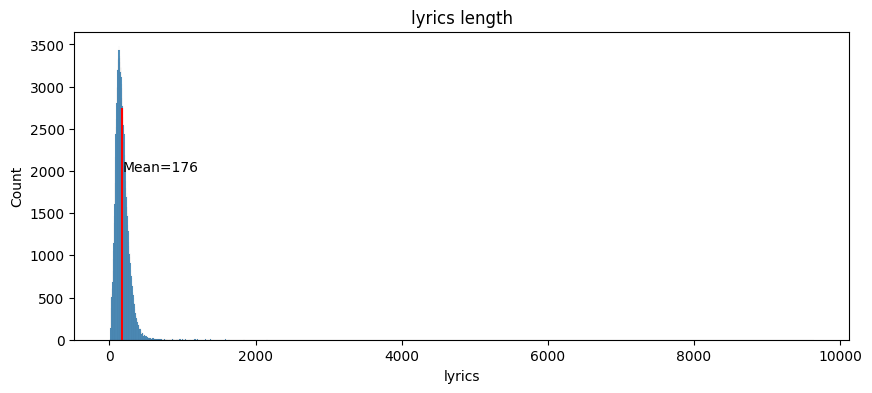

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(text_lengths)
plt.title('lyrics length')
plt.axvline(x=np.mean(text_lengths), ymin=0, ymax=0.75, color='r')
plt.text(np.mean(text_lengths), 2000, f'Mean={int(np.mean(text_lengths))}')
plt.show()

In [ ]:
BOW = {word[0]: ind + 1 for ind, word in enumerate(BOW.most_common())}

In [ ]:
pad_length = 15

def padding(sequence):
  while len(sequence) < pad_length:
    sequence.append(len(BOW.keys()) + 1)
  if len(sequence) > pad_length:
    sequence = sequence[:pad_length]
  return sequence

In [ ]:
def encode_text(text):
  words = text.lower().split()
  row_encoded = []
  for word in words:
    try:
      row_encoded.append(BOW[word])
    except KeyError:
      row_encoded.append(len(BOW.keys()))
  row_encoded = np.array(padding(row_encoded))
  return row_encoded

In [ ]:
df['enc'] = df['lyrics'].progress_apply(encode_text)
df

100%|██████████| 158484/158484 [00:18<00:00, 8626.92it/s]


,tag,lyrics,enc
0,0,только степь вздохнёт едва как божию росой тра...,"[102, 12505, 99425, 2463, 22, 129904, 22845, 2..."
1,1,stop fuckin gredy е loco let go bitch visagang...,"[1410, 5185, 30317, 23, 6159, 491, 217, 156, 1..."
2,1,будущие мамы хвастайте телами парни бойтесь об...,"[27385, 1620, 79463, 9004, 572, 18074, 53983, ..."
3,1,зимнее утро зимнее утро будильник шесть сорок ...,"[43646, 484, 43646, 484, 7342, 1021, 2481, 112..."
4,1,я помню детстве миг девственник заняв неизвест...,"[1, 157, 2009, 565, 31718, 95358, 17999, 5887,..."
...,...,...,...
158967,2,сколько историй вся жизнь повторе вернулся изг...,"[89, 3884, 183, 35, 5003, 1949, 16721, 5306, 3..."
158968,0,я могу найти милкис дорой купи пожалуйста милк...,"[1, 68, 254, 53972, 51852, 3201, 1161, 53972, ..."
158969,1,мутный мрак records камоловский синдикат produ...,"[13640, 1299, 11540, 595964, 18198, 9009, 12, ..."
158970,1,интро evil empire laughing way bank go don sto...,"[3240, 14977, 21190, 61258, 1454, 4328, 217, 2..."


## Let's split the data

In [ ]:
lyrics = np.array(df['enc'].to_list())
labels = np.array(df['tag'].to_list())

x_train, x_test, y_train, y_test = train_test_split(lyrics, labels, test_size=0.2, stratify=labels)

## Now let's undersample

(array([24482.,     0.,     0.,     0.,     0., 15382.,     0.,     0.,
            0., 15382.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

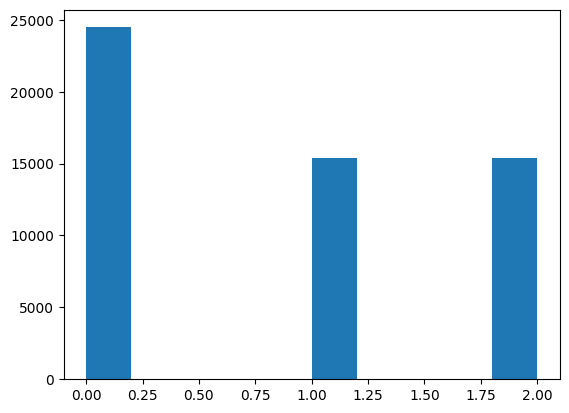

In [ ]:
randomsample = RandomUnderSampler(sampling_strategy="majority")
lyrics, tag = randomsample.fit_resample(x_train, y_train)

plt.hist(tag)

# Model: CNN + RNN

##The architechture

In [ ]:
embedding_size = 12

model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(BOW) + 2, output_dim=embedding_size))
model.add(layers.SimpleRNN(32, return_sequences=True))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation = 'sigmoid'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 12)          7151688   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 32)          1440      
                                                                 
 conv1d (Conv1D)             (None, None, 64)          6208      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                        

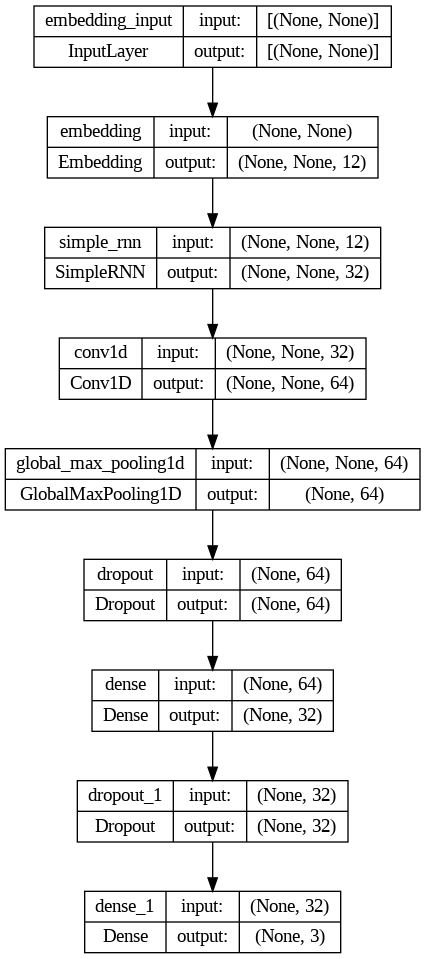

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

## The training

In [ ]:
# training the model

history = model.fit(lyrics, tag, epochs=5, batch_size=1024, validation_split=.2)

Epoch 1/5
44/44 [==============================] - 9s 163ms/step - loss: 0.9755 - accuracy: 0.5314 - val_loss: 2.1100 - val_accuracy: 0.0000e+00
Epoch 2/5
44/44 [==============================] - 8s 173ms/step - loss: 0.8791 - accuracy: 0.6001 - val_loss: 2.0434 - val_accuracy: 0.0000e+00
Epoch 3/5
44/44 [==============================] - 7s 151ms/step - loss: 0.7216 - accuracy: 0.7190 - val_loss: 2.1180 - val_accuracy: 0.0000e+00
Epoch 4/5
44/44 [==============================] - 8s 184ms/step - loss: 0.5281 - accuracy: 0.8028 - val_loss: 2.8614 - val_accuracy: 0.0197
Epoch 5/5
44/44 [==============================] - 7s 162ms/step - loss: 0.3527 - accuracy: 0.8751 - val_loss: 3.3396 - val_accuracy: 0.0990


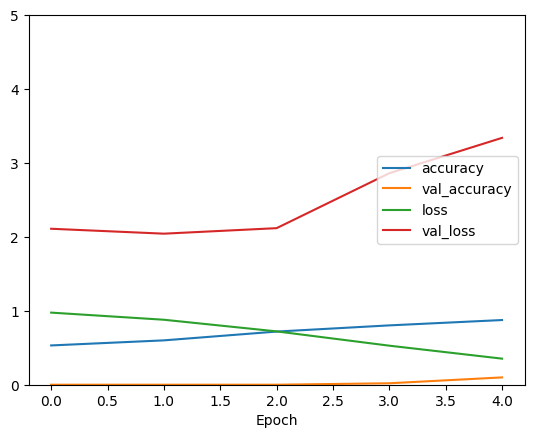

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylim([0.0, 5])
plt.legend(loc='right')
plt.show()

## Evaluation on test samples

In [ ]:
y_predict = model.predict(x_test)
prediction = np.argmax(y_predict, axis=1)

991/991 [==============================] - 5s 5ms/step


In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.30      0.71      0.42      6121
           1       0.84      0.60      0.70     21731
           2       0.24      0.10      0.14      3845

    accuracy                           0.56     31697
   macro avg       0.46      0.47      0.42     31697
weighted avg       0.66      0.56      0.58     31697



# Conclusion



There is room for improvement, clearly.

1. I managed to create CNN+RNN neural network.
2. Despite undersampling, the training results aren't perfect. I suspect that the model is overtrained.
3. On the other hand, the loss and accuracy are improving, so maybe the issue is in the validation - the samples in it are not representative.
4. I tried changing the structure, changing batches, learning rate - it didn't change val_loss.
5. So the question of val_loss remains unaswered.